In [ ]:
#pip install tsfel


In [1]:
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn import svm
from scipy import signal

import matplotlib.pyplot as plt
import scipy.io as sio
# import neurokit2 as nk
import seaborn as sns

import pandas as pd
import numpy as np
import time

In [2]:
import ast
import csv
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
import scipy.signal as signal
import tsfel
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


pd.options.display.max_colwidth = 999
pd.options.display.max_columns = None

In [4]:
def typeChange(c):
    try:
        if '[' in c:    # checking if it is a list, for some reason can't do or ']', because ints return as a list
            retList = [int(x) if x.isdigit() else str(x) for x in c.strip('[]').split(' ')]
            return retList
        if c=='True':
            return True
        elif c=='False':
            return False
        return int(c)
    except:
        return c

In [6]:
# Signal Preprocessing
df = pd.read_csv("/Users/olumide/Documents/Dissertation/Olumide's data/Olu First Experiment/MyFitbitData/OlumideOdetunde/Heart/Afib ECG Readings.csv")
# for i in df.waveform_samples:
#     y = df.waveform_samples[i]
waveform_samples =  df.waveform_samples[1]
waveform_sample = typeChange(waveform_samples)
waveform_sample = pd.DataFrame({'waveform':waveform_sample})
waveform_sample.waveform = pd.to_numeric(waveform_sample.waveform, errors='coerce').dropna().astype(int)
waveform_sample = waveform_sample.dropna().reset_index()
waveform_sample = waveform_sample.waveform
waveform_sample = waveform_sample.astype(int)
waveform_sample.dtypes

df_waveform_sample = pd.DataFrame(waveform_sample)


In [7]:
y = [y for y in waveform_sample]
n = len(y) #number of sample points

# Sample spacing
fs = 1000
t = 1.0/fs

# x-axis
x = np.linspace(0.0, n*t, n)

#Apply fourier transform to waveform transform
yf = scipy.fftpack.fft(y)

#compute frequency of x-axis
xf = np.linspace(0.0, 1.0/(2.0*t), int(n/2))


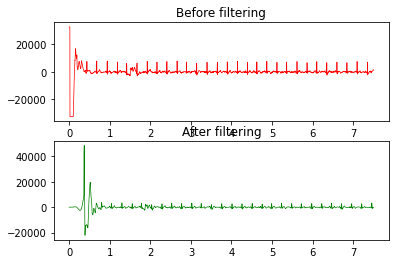

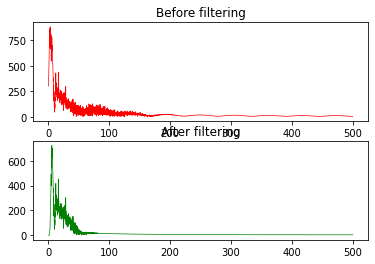

In [8]:
fig_td = plt.figure()
# fig_td.set_window_title('Time domain signals')
fig_fd = plt.figure()
# fig_fd.set_window_title('Frequency domain signals')
ax1 = fig_td.add_subplot(211)
ax1.set_title('Before filtering')
ax2 = fig_td.add_subplot(212)
ax2.set_title('After filtering')
ax3 = fig_fd.add_subplot(211)
ax3.set_title('Before filtering')
ax4 = fig_fd.add_subplot(212)
ax4.set_title('After filtering')  

# Plot non-filtered inputs
ax1.plot(x,y, color='r', linewidth=0.7)
ax3.plot(xf, 2.0/n * np.abs(yf[:n//2]), color='r', linewidth=0.7, label='raw')
# ax3.set_ylim([0 , 0.2])


b, a = signal.butter(4, 50/(fs/2), 'low') #compute filtering co-efficients

#compute filtered signals
tempf = signal.filtfilt(b,a, y)
#b, a = signal.butter(1, band_filt/(Fs/2), 'bandstop')
tempf = signal.filtfilt(b,a, y)
yff = scipy.fftpack.fft(tempf)



#Compute Kaiser Window Coefficient to creatae a lowpass FIR filter
nyq_rate = fs/ 2.0
# The desired width of the transition from pass to stop.
width = 5.0/nyq_rate
# The desired attenuation in the stop band, in dB.
ripple_db = 60.0
# Compute the order and Kaiser parameter for the FIR filter.
O, beta = signal.kaiserord(ripple_db, width)
# The cutoff frequency of the filter.
cutoff_hz = 4.0


 ###Use firwin with a Kaiser window to create a lowpass FIR filter.###
taps = signal.firwin(O, cutoff_hz/nyq_rate, window=('kaiser', beta), pass_zero=False)
# Use lfilter to filter x with the FIR filter.
y_filt = signal.lfilter(taps, 1.0, tempf)
yff = scipy.fftpack.fft(y_filt)

#Plot filtered outputs
ax4.plot(xf, 2.0/n * np.abs(yff[:n//2]), color='g', linewidth=0.7)
# ax4.set_ylim([0 , 0.2])
ax2.plot(x,y_filt, color='g', linewidth=0.7)
plt.show()

### Computing Heart Beat

In [ ]:
df_waveform_sample.waveform.plot()

In [ ]:
df_waveform_sample['filtered'] = y_filt
df_waveform_sample.filtered.plot()

In [36]:
#Feature Extraction

cfg = tsfel.get_features_by_domain()

X = tsfel.time_series_features_extractor(cfg,df_waveform_sample.filtered)

df_features = pd.DataFrame(X)
# df_features['label'] = 'fear'
df_features

label = pd.DataFrame({'label':[1]})
label

*** Feature extraction started ***
60


/var/folders/1t/7mfrmh2s0r17tk3yntzzmsjw0000gn/T/ipykernel_7995/929299952.py:5: UserWarning: Using default sampling frequency set in configuration file.
  X = tsfel.time_series_features_extractor(cfg,df_waveform_sample.filtered)


,label
0,1


In [40]:
#model fitting


label = label.to_numpy

model = SVC() 
model.fit(df_features,label)

ValueError: y should be a 1d array, got an array of shape () instead.

### Model CODE from Git

In [50]:
def run_clf(clf):
    cv = GroupKFold(n_splits=10)
    score = []
    runtime = []
    for fold, (train, test) in enumerate(cv.split(X, y, groups)):
        clf.fit(X[train], y[train])
        start = time.time()
        score.append(clf.score(X_test, y_test))
        runtime.append(time.time() - start)

    return score, runtime
results = []
names = ["Nearest Neighbors", "Linear SVM",
         "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest",
         "Neural Net", "AdaBoost",
         "Naive Bayes"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5,
                           n_estimators=10,
                           max_features=1),
    MLPClassifier(alpha=1,
                  max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB()]

for name, classifier in zip(names, classifiers):
    clf = make_pipeline(MinMaxScaler(), classifier)
    score, runtime = run_clf(clf)
    results.append([name,
                    np.mean(score),
                    np.mean(runtime)])
results_df = pd.DataFrame(results, columns=['name',
                                            'mean_score',
                                            'mean_runtime'])
results_df.to_csv('results.csv')

NameError: name 'groups' is not defined

### Experimentation

In [6]:
def clean_alt_list(list_):
    list_ = list_.replace(', ', '","')
    list_ = list_.replace('[', '["')
    list_ = list_.replace(']', '"]')
    return list_

In [7]:
df = pd.read_csv("/Users/olumide/Documents/Dissertation/Olumide's data/Olu First Experiment/MyFitbitData/OlumideOdetunde/Heart/Afib ECG Readings.csv")
df_2  = df.copy()
df_2['waveform_samples'] =  df_2['waveform_samples'].apply(clean_alt_list)
df_2

,reading_id,reading_time,wire_id,result_classification,heart_rate,heart_rate_alert,firmware_version,device_app_version,hardware_version,waveform_samples
0,24acf5e0-e4f8-11ec-8080-808080808080,Sun Jun 05 17:51:35 UTC 2022,497267d1532c,NSR,63,NONE,128.6.12,2.9.0,Sense,"[""-32768 -32768 -32768 -32768 -32768 -327..."
1,cc22f1a0-e325-11ec-8080-808080808080,Fri Jun 03 10:13:21 UTC 2022,497267d1532c,NSR,60,NONE,128.6.12,2.9.0,Sense,"[""32767 32767 32767 32767 32767 32767 32..."


In [12]:
x = to_1D(df_2.waveform_samples)
x = pd.DataFrame({'waveform sample': x})
x
#to_1D(df_2.waveform_samples).value_counts()

,waveform sample
0,[
1,""""
2,-
3,3
4,2
...,...
85097,2
85098,6
85099,4
85100,""""


In [32]:
waveform_expanded = df['waveform_samples'].apply(pd.Series)
waveform_expanded

,0
0,[-32768 -32768 -32768 -32768 -32768 -3276...
1,[32767 32767 32767 32767 32767 32767 327...
